In [1]:
#! nvidia-smi

In [2]:
#conda install pytorch torchvision -c pytorch

In [3]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker

# # ps
# import pysindy as ps

# sns.set_theme()
# torch.set_default_dtype(torch.float32)
plt.rcParams['text.usetex'] = True

In [5]:
dim = 6
torch.set_default_dtype(torch.float64)

# Dataset for X

In [6]:
from BeadModel import Simulate
from SimulationParameters import *

X = Simulation(*Simulate(numSims)).positions[:,:,:,0].reshape(-1,nt+1).T
# Z = X.view

print(X.shape)
# print(X)

(1001, 6)


# Set the NN model and Solver with training process

In [7]:
def relu2(X): return func.relu(X)**2
def tanh(X): return func.tanh(X)
class FCNN(nn.Module):
    def __init__(self,input_dim=6,output_dim=6,num_hidden=2,hidden_dim=10,act=func.tanh,transform=None):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers  = nn.ModuleList([nn.Linear(input_dim,hidden_dim)])
        for _ in range(num_hidden-1): self.layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.act     = act
        self.out     = nn.Linear(hidden_dim,output_dim)
        self.transform = transform
    def forward(self,X):
        if self.transform is not None: X = self.transform(X)
        for layer in self.layers: X = self.act(layer(X))
        Y = self.out(X)
        return Y
class Model(nn.Module):
    def __init__(self,dim,model_U,unit_len=int(5e3)):
        super().__init__()
        self.dim      = dim
        self.model_U  = model_U
        self.unit_len = unit_len
        self.mu       = nn.Parameter(torch.tensor([0.]*dim),requires_grad=False) 
        self.sigma    = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        #above two lines should work, but if something doesn't work, check here! Does current self.mu and self.sigma code work if dim>1. Should return a vector since what we're trying to do is calculate mu
        #and sigma separately for each imnputted feature. mu is parameter[0] for each row.
        self.coef_U   = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        #self.mu       = nn.Parameter(torch.tensor([0.]*dim).cuda(),requires_grad=False)
        #self.sigma    = nn.Parameter(torch.tensor([1.]*dim).cuda(),requires_grad=False)
        #self.coef_U   = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=False)
    def get_U_harmonic(self,X): return torch.sum(X**2,axis=-1)
        
    
    def get_U_dU(self,X):
        # normalize and ensure x is a tensor
        if not torch.is_tensor(X): X = torch.tensor(X, requires_grad=True)
        U = self.model_U(X).view(-1)
        dU = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        # dU = dU.T
        return U,dU

    
    def get_U_np(self,X): 
        U,_ = self.get_U_dU(X);
        return U.cpu().data.numpy()
    
    # def get_U_numerical_integration(self,X, dX):
    #     outputU = []
    #     _,dU = self.get_U_dU(X)
    #     # Assume dU has more than two features. for each timestep we'll numerically integrate. current shape is 6x10
    #     #Trapezoid rule for numerical integration by each timestep
    #     for t in range(dU.shape[1]):
    #         currentSum = 0
    #         currentDU = dU[:,t]
    #         for i in range(len(currentDU)):
    #             if i == len(currentDU)-1 or i == 0:
    #                 currentSum += currentDU[i] / 2
    #             else:
    #                 currentSum += currentDU[i]
    #         currentSum *= dX
    #         outputU.append(currentSum + sum(outputU))
    #     U = torch.tensor(outputU)
    #     return U

    def get_U_numerical_integration(self,X, dX):
        U = []
        _,dU = self.get_U_dU(X)
        # print(dU.shape) #1001 by 6
        # Assume dU has more than two features. for each timestep we'll numerically integrate. current shape is 6x10
        #Trapezoid rule for numerical integration by each timestep
        for t in range(dU.shape[0]):
            currentPartialSumofU = 0
            currentDU = dU[t,:]
            for i in range(len(currentDU)):
                if i == len(currentDU)-1 or i == 0:
                    currentPartialSumofU += currentDU[i] / 2
                else:
                    currentPartialSumofU += currentDU[i]
            currentU = currentPartialSumofU * dX
            U.append(currentU)
        
        U = torch.tensor(U , requires_grad=False)
        # print(U.shape) #shape 6
        return U

    
class Solver():
    def __init__(self,model):
        self.model=model
    def train_model(self,data_train,data_test,get_loss,optimizer,
                    n_steps,batch_size,scheduler=None,n_show_loss=100,error_model=None,use_tqdm=True):
        if use_tqdm: step_range = tqdm(range(n_steps))
        else: step_range = range(n_steps)
        loss_step = []
        for i_step in step_range:
            if i_step%n_show_loss==0:
                loss_train,loss_test = get_loss(self.model,data_train)[:-1],\
                                       get_loss(self.model,data_test)[:-1]
                
                def show_num(x): 
                    if abs(x)<100 and abs(x)>.01: return '%0.5f'%x
                    else: return '%0.2e'%x
                item1 = '%2dk'%np.int_(i_step/1000)
                item2 = 'Loss: '+' '.join([show_num(k) for k in loss_train])
                item3 = ' '.join([show_num(k) for k in loss_test])
                item4 = ''
                if error_model is not None: item4 = 'E(QP): %0.4f' % (error_model(self.model))
                # print(', '.join([item1,item2,item3,item4]))
                loss_step = loss_step + [i_step] + [k.cpu().data.numpy() for k in loss_train]\
                                                 + [k.cpu().data.numpy() for k in loss_train]
            data_batch = data_train[random.sample(range(len(data_train)),
                                                  min(batch_size,len(data_train)))]
#             print(i_step,data_batch.shape)
            loss = get_loss(self.model,data_batch)[-1]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
        if error_model is not None: 
            print("Error: %0.5f" % (error_model(self.model)))
        return loss_step

In [8]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

In [9]:
# print(model.get_U_dU(X))

In [10]:
# print(model.mu.shape)
# print(model.mu)

In [11]:
# def plot_model(model,cmap='terrain',max_V = 10):
    
#     xx     = np.linspace(0,2,1000).reshape(-1,1)
#     U_NN   = model.get_U_np(xx)
#     U_NN_min = U_NN.min()
#     U_NN  = U_NN-U_NN_min

#     fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
#     c      = ax.plot(xx[:,0],U_NN,'-',lw=1.5,)

#     ax.tick_params(axis="both", labelsize=10)
#     plt.show()

# Set the loss function and Train the model for differen a_k(x)

In [12]:
from Loss import getResidue, getAllResidues

# def plot_model(model,cmap='terrain',max_V = 10):
    
#     # xx     = np.linspace(0,2,1000).reshape(-1,1)
#     # U_NN   = model.get_U_np(xx)
#     U_NN   = model.get_U_np(X)
#     U_NN_min = U_NN.min()
#     U_NN  = U_NN-U_NN_min
#     fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
#     c      = ax.plot(X[:,0],U_NN,'-',lw=1.5,)

    # ax.tick_params(axis="both", labelsize=10)
    # plt.show()

def plot_model(model,cmap='terrain',max_V = 10,):
    xx     = np.linspace(0,2,nt).reshape(-1,1)
    U_NN = model.get_U_numerical_integration(X, dX = 1/500)
    U_NN = U_NN[:nt]
    # U_NN_min = U_NN.min()
    # U_NN  = U_NN-U_NN_min
    fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
    c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5)

def get_loss(model,data):
    X = data
    X = torch.tensor(X).clone().detach().requires_grad_(True)
    _,dU = model.get_U_dU(X)
    loss = getAllResidues(X, dU)
    return loss#,loss


# plot_model(model)
get_loss(model,X)

[tensor(-0.0244, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0210, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0193, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0208, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0237, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0286, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0302, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0299, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0290, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0322, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0336, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0352, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0377, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0371, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0382, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0372, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0371, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0379, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0390, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0375, grad_fn=<LinalgDetBackward0>),
 tensor(-0.0391, grad_fn=<LinalgDetBackw

  0%|          | 0/50001 [00:00<?, ?it/s]

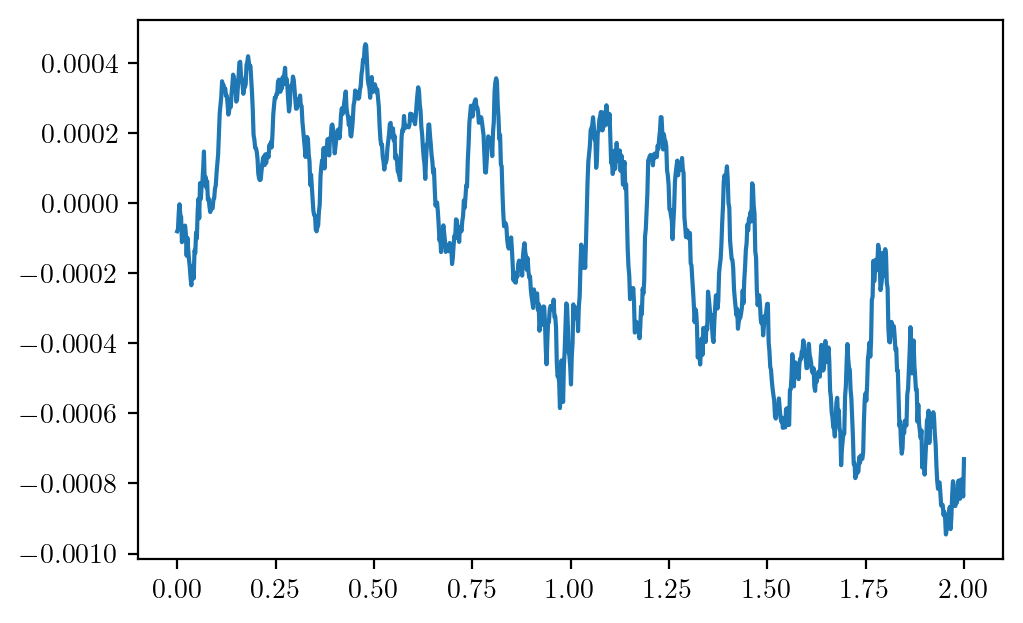

In [13]:
#for choose_id in [1,2,3]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

# print(model.mu,model.sigma,model.coef_U)
    #optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001))
scheduler = None
_loss_step = SOL.train_model(data_train=X,data_test=X,
                             get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                             n_steps=int(5e4+1),batch_size=500,n_show_loss=1000,use_tqdm=True)

# 5e4+1
torch.cuda.empty_cache()
plot_model(model)
# torch.save(model.state_dict(), "savee/model_"+str(choose_id))
#torch.save(model.state_dict(),"savee/model_anaconda3")

In [14]:
#torch.save(model.state_dict(), "savee/model_99")
#model.state_dict()

In [15]:
# fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
# xx       = np.linspace(0,2,1000).reshape(-1,1)
# U_NN     = model.get_U_np(xx)
# U_NN_min = U_NN.min()
# U_NN     = U_NN-U_NN_min
# c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5)
# ax.legend(fontsize=10)
# ax.set_xlabel('$x$',fontsize=10)
# ax.set_ylabel('$U(x)$',fontsize=10)
# ax.set_xlim([0,2])
# ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
# ax.set_xticks([0,.5,1.,1.5,2])
# ax.yaxis.grid(linestyle='--')
# ax.tick_params(axis="both", labelsize=10)
# plt.show()

In [16]:
# U_NN

# Visualizing the results for different a_k(x)

In [17]:
def plot_models(models):
    
    xx       = np.linspace(0,2,1000).reshape(-1,1)
    fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
    
    for k,model_name in enumerate(models):
        model.load_state_dict(torch.load(model_name))
        U_NN     = model.get_U_np(xx)
        U_NN_min = U_NN.min()
        U_NN     = U_NN-U_NN_min
        c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5,label="$a_{%d}(x)$"%(k+1))
    ax.legend(fontsize=10)
    ax.set_xlabel('$x$',fontsize=10)
    ax.set_ylabel('$U(x)$',fontsize=10)
    ax.set_xlim([0,2])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
    ax.set_xticks([0,.5,1.,1.5,2])
    ax.yaxis.grid(linestyle='--')
    ax.tick_params(axis="both", labelsize=10)
    plt.show()
    
# plot_models(["savee/model_anaconda3"])
#plot_models(["savee/model_a1_update", "savee/model_a2_update", "savee/model_a3_update", "savee/model_a4", "savee/model_a5_update"])

In [18]:
# model

In [19]:
# torch.load("/Users/annacoletti/Desktop/savee/model_a3_update.mat")

In [20]:
# import scipy.io as scio
# from scipy.io import savemat
# scio.savemat('W2_learned_DL', U_NN)